In [1]:
# don't change this cell; just run it
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
# safe settings for Pandas
pd.set_option('mode.chained_assignment', 'raise')
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append("src/")
from population_sample_image_generator import *
from central_limit_illustration import *

# make the plots look more fancy
plt.style.use('fivethirtyeight')

# Confidence intervals

- We'll look at confidence intervals via modern, code-based methods - both for explaining what they mean, and how to generate them.

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).

## A data scientist's predicament

Consider this scenario: a data scientist has been asked to help with a research project in the field of historical epidemiology - analysing historical datasets related to health. 

Her task at the moment is simply to calculate the average birthweight of babies born at a small hospital in Oakland, California in the year 1960. She is to do this in order to later test the hypothesis that babies born at this hospital in this year were underweight, relative to the national average at that time. 

However, the data scientist is in a predicament.  Initially, she was granted access to a random sample of 25 baby records whilst waiting for clearance from the hospital's medical records department to access the complete dataset. The complete dataset includes the birthweights for all 1236 babies born at that hospital in 1960.

But disaster has struck, and the hospital's medical records department are refusing the data scientist access to the full dataset, owing to concerns about data privacy. (Alas, research rarely goes to plan!).

At the moment, she only has her random sample of 25 babies, which is shown as the output of the code cell below:

In [2]:
# load in the sample data (this IS real data!)
babies_sample = pd.read_csv('data/babies_sample.csv').round(2)

# show the sample data
babies_sample

,birthweight_kg
0,4.00
1,3.32
2,4.11
3,3.66
4,2.72
5,2.98
6,3.71
7,3.83
8,3.52
9,2.44


Here is the histogram of the data scientist's sample, and along with it's sample mean:

*Note*: I am using "mean" and "average" interchangeably throughout this tutorial.

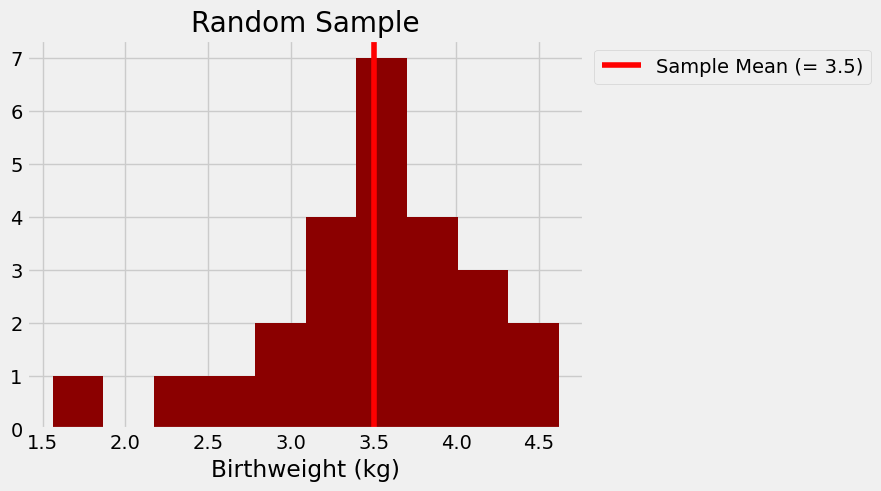

In [3]:
# calculate the sample mean
sample_mean = babies_sample['birthweight_kg'].mean()

# plot the sample, and its mean
plt.hist(babies_sample['birthweight_kg'], color = 'darkred')
plt.axvline(sample_mean, color = 'red', label = f"Sample Mean (= {round(sample_mean, 2)})")
plt.xlabel('Birthweight (kg)')
plt.title('Random Sample')
plt.legend(bbox_to_anchor = (1,1));

Now, our she doesn't care specifically about the mean birthweight of this random sample of 25 babies; *she cares about the mean birthweight of all 1236 babies born in 1960, at the hospital*. Let's refer to these 1236 babies as the *population* she is interested in.

Somehow she needs to use her sample and its average birthweight to accurately estimate the population's average birthweight.

> <b> Question: </b> can our data scientist simply present her sample average as an estimate of the population average? E.g. can she say something like "well, the sample was random, and therefore probably representative of the population, so the mean population birthweight probably is the same as the mean sample birthweight"?

Our data scientist *could* simply take the average birthweight of her sample and report it as the estimated population birthweight, but she knows that her random sample is just one of many possible random samples. She knows that, on a different day, different babies' records would have made it into her random sample, and the sample's average birthweight would probably have been different. Consequently, were she to use the sample average as her estimate of the average population birthweight, her estimate would have been different as well.

If her estimate very easily could have been different, then why should she believe that her specific sample contains the best estimate of the population mean?

Because of these concerns, she is reluctant to use the sample mean *by itself* as an estimate of the population mean.

## An all-knowing perspective

Let's not just take our data scientist's word here though - let's use the power of code to empirically demonstrate the principles behind her concerns.

In order to do this I'd like you to imagine that we (everyone present today) do have access to the full dataset. Let's imagine we work in another department at the hospital, and we can view the full data. (**But** we're not allowed to share the population data - or anything derived from the population data - with anyone outside of the hospital).

Here is the full dataset, containing the birthweights of all babies born in 1960 at the hospital:

In [4]:
# load in the population data
babies_pop = pd.read_csv('data/babies.csv').round(2)

# show the data
babies_pop

,birthweight_kg
0,3.40
1,3.20
2,3.63
3,3.49
4,3.06
...,...
1231,3.20
1232,3.63
1233,3.69
1234,3.54


From our luxury, all-knowing viewpoint, we can just plot the population data, and "peek" at the population mean:

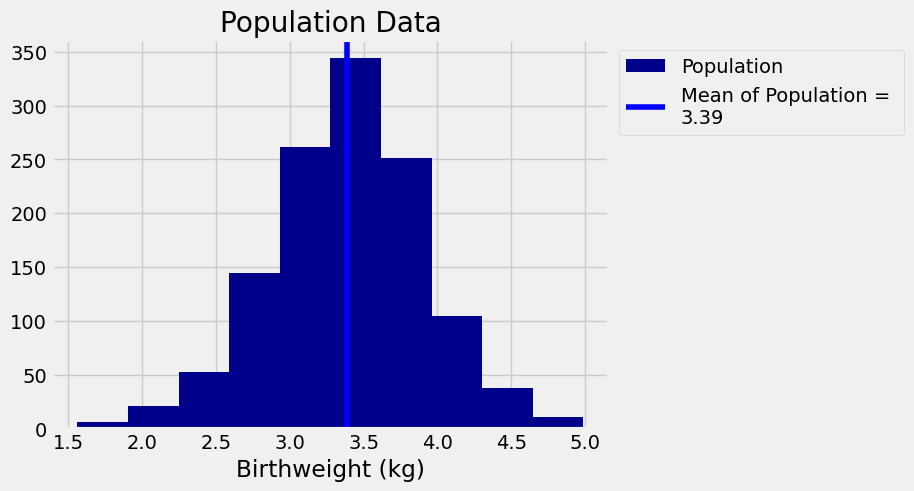

In [5]:
# plot a histogram, show the pop and pop mean
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')

# store the population mean as a variable
population_mean = babies_pop["birthweight_kg"].mean().round(2)

plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# add axis labels and legend
plt.xlabel('Birthweight (kg)')
plt.legend(bbox_to_anchor = (1,1))
plt.title('Population Data');

From our seemingly all-knowing position of being able to "see" the full population data, we can get a vivid feel for our data scientist's concerns. Because we have access to the population data we can easily draw new random samples of 25 babies. We can do this as many times as we like, so we can not only see how far off each sample average is from the actual population mean, we can also build an intuition as to how much sample averages vary as we draw lots of random samples (highlighting the issue our data scientist is concerned by).

The code cell below draws a random sample from the population data:

In [12]:
# draw a new sample
new_sample = babies_pop.sample(25)

# show the new sample and the mean
display(Markdown(f"\nNew sample mean = {np.mean(new_sample['birthweight_kg']).round(2)}"))
display(new_sample.round(2))


New sample mean = 3.39

,birthweight_kg
189,2.72
296,3.37
902,3.18
658,4.00
1048,3.86
666,3.20
794,3.12
1023,4.25
116,4.00
240,4.08


From our omniscient perspective, let's draw another random sample and let's plot it against the population data, so we can see graphically how close or far our sample average is from the population average.

Through running this code cell multiple times, we can build an intuition for how much the sample averages vary, over repeated samples.

As we run the cell multiple times, let's evaluate how accurate it would be to use each single sample's mean as an estimate of the population mean - this will show us why our data scientist is reluctant to "trust" the mean of her single sample as an estimate of the population average:

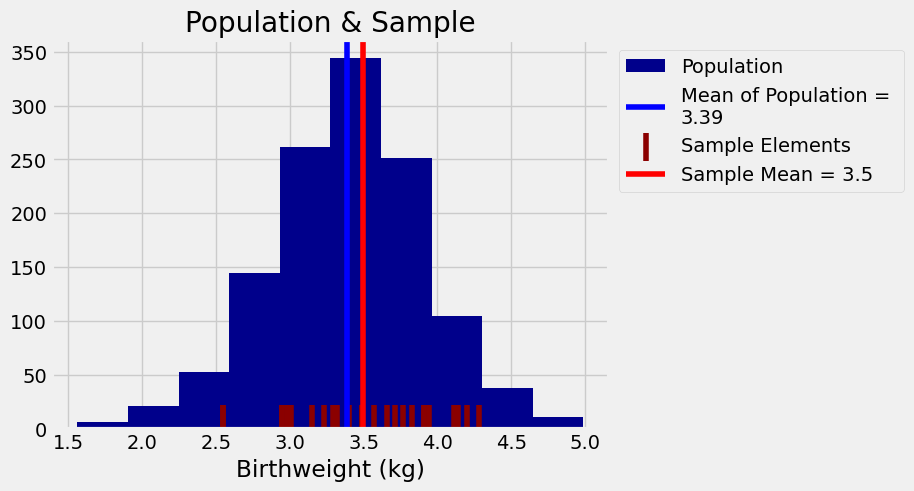

In [18]:
# draw a new random sample
new_sample = babies_pop["birthweight_kg"].sample(25)

# plot a histogram, show the pop and pop mean
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# show the new sample and new sample mean
plt.scatter(new_sample, np.repeat(9, len(new_sample)), 
            marker = "|", s = 400, 
            color = 'darkred',
            label = 'Sample Elements')
plt.axvline(new_sample.mean(), color = "red",
            label = f'Sample Mean = {new_sample.mean().round(2)}')
    
# add axis labels and legend
plt.xlabel('Birthweight (kg)')
plt.legend(bbox_to_anchor = (1,1))
plt.title('Population & Sample');

## Plus or minus a bit

So, from our omniscient viewpoint, we have seen that sample means do not always capture the population mean.

Sometimes sample means are higher than the population mean, sometimes they are lower than the population mean.

Sometimes the difference between the sample mean from the population mean is large, sometimes it is small.

This phenomenon is called *sampling error* - sample averages tend to deviate from the population average, even when the sample is random.

So when our data scientist is questioning whether her sample average is a good representation of the population average, she knows that the answer is something like:

> "Because of sampling error the population mean is going to be my sample mean **plus or minus a bit**".

This "plus or minus a bit" here entails that her sample average is an *uncertain* estimate of the population average.

But how uncertain is her estimate? How does she know how big "plus or minus a bit" might be? 

Currently, two things that would be relevant for answering this question are hidden from our data scientist:

- The population mean itself

- The amount by which sample means from different random samples typically vary from each other

If she knew the population mean, she wouldn't have to infer anything from her sample. She could just report the population mean to the rest of her reserch team, and proceed with the rest of the project.

But, even without knowing the true population mean, if our data scientist could generate multiple random samples and calculate the mean for each, she could see how much these sample means vary from each other. By considering the range or 'spread' of these sample means, she could construct an interval in which the population mean probably lies, as she knows that spread represents the other random samples that she easily could have got.

This interval is a *confidence interval*. It gives us a precise estimate to how big "plus or minus a bit" is, when we say "the population mean is probably our sample mean, plus or minus a bit".

## Confidence intervals - from our "all knowing" perspective

This might all sound a bit abstract. So let's convince ourselves it is true using code. Our data scientist can't draw new random samples from the population - but from our luxury perspective we can.

The code cell below repeats some code 1000 times. On each repeat, it draws a new random sample of 25 babies (just as in the code cells above). Each time a new sample is drawn, the mean of that sample is calculated. Once the code has run, we will have the means of 1000 random samples, drawn from the population data. This will tell us how much the means of random samples tend to vary from each other:

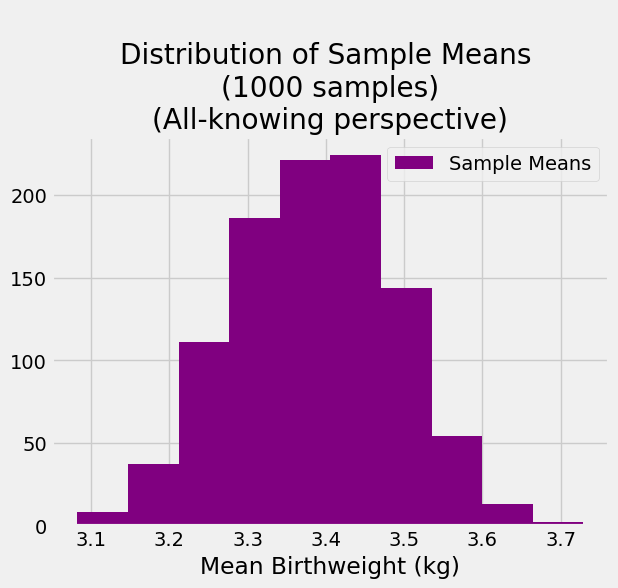

In [19]:
# set how many samples to draw
number_of_samples = 1000

# an empty array to store the sample means
sample_means = np.empty(number_of_samples)

# over 1000 repeats
for i in np.arange(1000):
    
    # draw a new random sample of 25 babies
    current_sample = babies_pop["birthweight_kg"].sample(25)
    
    # calculate and store the mean of the current sample
    sample_means[i] = current_sample.mean()

# plot the distribution of the sample means
plt.hist(sample_means, color = 'purple', label = 'Sample Means')
plt.legend(bbox_to_anchor = (1, 1))
plt.xlabel('Mean Birthweight (kg)')
plt.title(f'\nDistribution of Sample Means \n({number_of_samples} samples)\n(All-knowing perspective)');

Let's just recap what we've done here: because we have the population data, we've been able to draw repeated random samples from it.

We've drawn 1000 random samples, and calculated the mean for each one.

The purple histogram above shows the distribution of the means of these 1000 samples.

This histogram can let us quantify the "plus or minus a bit" mentioned above - because it shows us how much sample averages tend to vary from each other.

Now, if we take the "spread" of this sampling distribution, we can construct an interval which quantifies "plus or minus a bit". We'll follow convention here, and grab the middle 95% of the distribution:

In [20]:
# get the middle 95% of the distribution of sample means
left_interval, right_interval = np.percentile(sample_means, [2.5, 97.5])
print('Left:', left_interval)
print('Right:', right_interval)

Left: 3.18433
Right: 3.5828200000000003


We now have the middle 95% of the sample means, obtained via our all-knowing perspective of being able to repeatedly draw new samples and calculating their means:

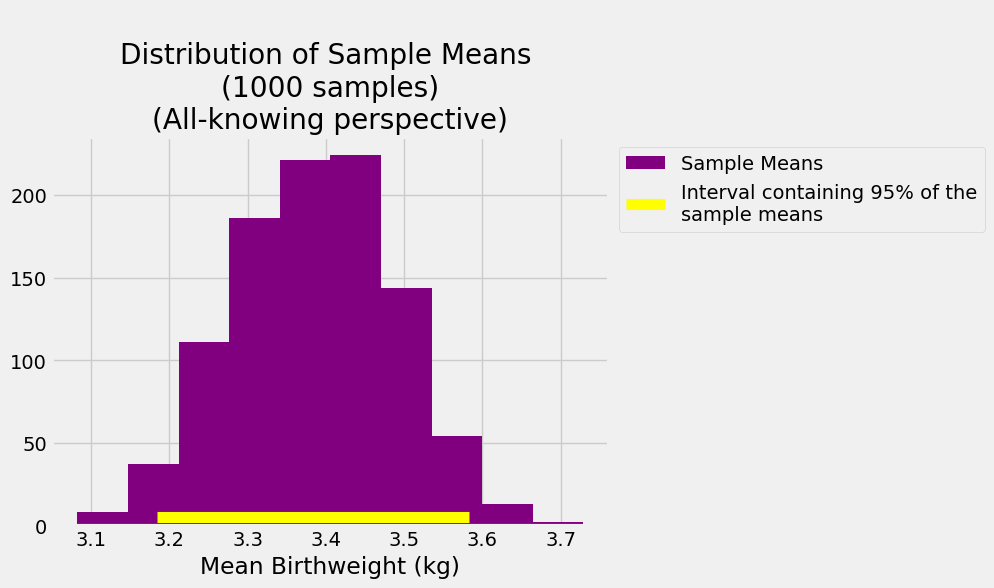

In [21]:
# plot the sampling distribution and the 95% interval
plt.hist(sample_means, color = 'purple', label = 'Sample Means')
plt.plot([left_interval, right_interval], [5, 5], color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nsample means")
plt.legend(bbox_to_anchor = (1, 1))
plt.xlabel('Mean Birthweight (kg)')
plt.title(f'\nDistribution of Sample Means \n({number_of_samples} samples)\n(All-knowing perspective)');

Let's calculate how "wide" the interval is - that tells us precisely what "plus or minus a bit is", as it tells us how much the sample means typically vary from each other, as we draw lots of random samples:

In [22]:
# calculate the width of the interval
width_of_interval = right_interval - left_interval

# show the width of the interval
width_of_interval 

0.39849000000000023

In [23]:
# minus "a bit"
- width_of_interval/2

-0.19924500000000012

In [24]:
# plus "a bit"
+ width_of_interval/2

0.19924500000000012

<b> What can we do with this interval? </b>

The code cell below draws a new random sample and shows its mean.

It uses the "spread" of the sampling distribution - which we just calculated - and "places" the spread as an interval around the new sample mean.

If we re-run the cell lots of times, we can see that a very high proportion of the time, the yellow interval contains the population mean:

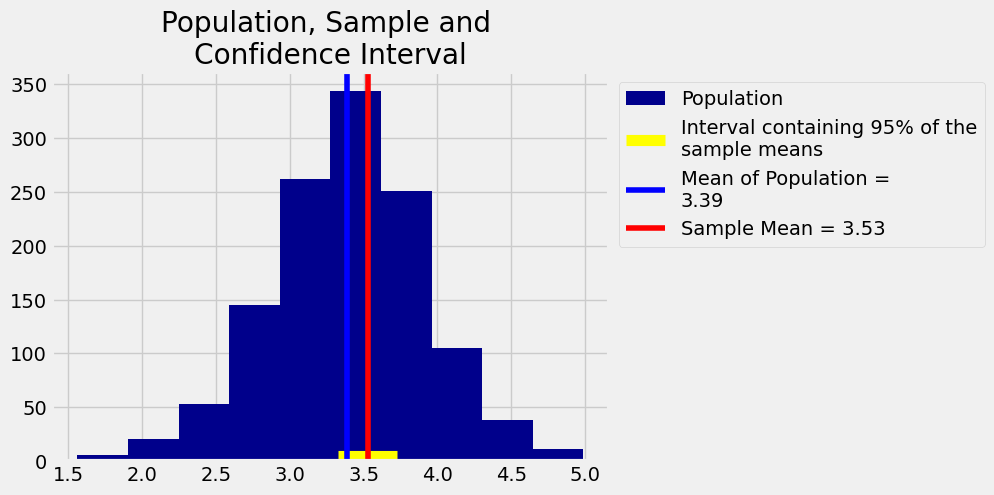

In [29]:
# draw a new random sample
new_sample = babies_pop["birthweight_kg"].sample(25)

# plot the population histogram
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')

# plot the confidence interval
plt.plot([new_sample.mean() - width_of_interval /2, new_sample.mean() + width_of_interval /2], [5, 5],
         color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nsample means")

# plot the population mean
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# plot the sample mean
plt.axvline(new_sample.mean(), color = "red",
            label = f'Sample Mean = {new_sample.mean().round(2)}')

plt.title('Population, Sample and \nConfidence Interval')
plt.legend(bbox_to_anchor = (1, 1));

The cell below repeats the code from the cell above 100 times (apart from plotting the graph!), and it shows the proportion of times over all 100 repeats that the interval around the sample mean contained the population mean

First, from our 'all-knowing' perspective we drew 1000 random samples from the population, and plotted a histogram of their means.

Then we calculated the interval 'picking out' the middle 95% of that distribution of means.

Then, we drew 100 NEW random samples.

For each new sample, the sample mean has been calculated. And we have 'placed' the interval over each sample mean.

<b>95.0% of these intervals, centred on each new sample mean, contained the population mean.</b>

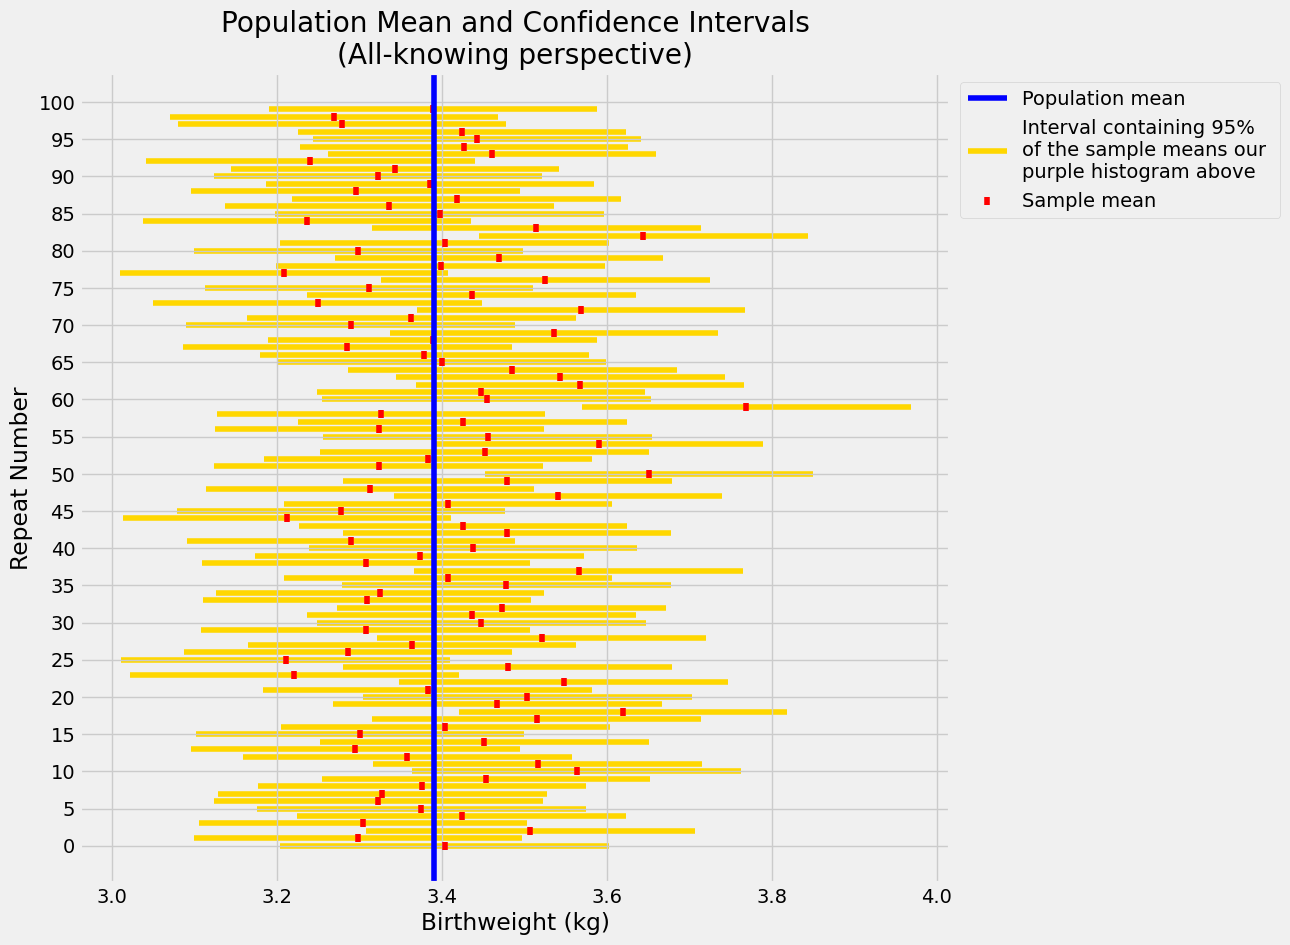

In [30]:
# set the number of repeats
number_of_repeats = 100

# an empty array, to record whether the interval contained
# the population mean, on each repeat
contains_population_mean = np.empty(number_of_repeats)

# empty arrays to store in the intervals themselves
left_intervals = np.empty(number_of_repeats)
right_intervals = np.empty(number_of_repeats)

# empty array to store the mean of each sample
one_hundred_sample_means = np.empty(number_of_repeats)

# on each repeat...
for i in np.arange(number_of_repeats):
    
    # draw a new sample
    current_sample = babies_pop["birthweight_kg"].sample(25)
    
    # store the sample mean
    one_hundred_sample_means[i] = current_sample.mean()
    
    # calculate the confidence interval, from the spread of the sampling 
    # distribution
    left_end_of_interval = current_sample.mean() - width_of_interval /2
    right_end_of_interval = current_sample.mean() + width_of_interval /2
    
    # store the intervals
    left_intervals[i] = left_end_of_interval 
    right_intervals[i] = right_end_of_interval
    
    # work out if the interval contains the population mean
    contains_population_mean[i] = np.logical_and(left_end_of_interval < population_mean, right_end_of_interval > population_mean)

    # set the figure size
plt.figure(figsize=(10,10))

# make a dataframe of confidence intervals, from the 100 repeats
intervals = pd.DataFrame({'Left': left_intervals,
                         'Right': right_intervals})

# plot each sample mean, in the centre of the interval
for i in np.arange(len(intervals)):
    ends = intervals[['Left', 'Right']].iloc[i]
    plt.plot(ends, [i, i], color='gold', zorder=0)
    plt.scatter(one_hundred_sample_means[i], i,
                color='red', marker = "|")

# plot the population mean and add graph labels
plt.axvline(population_mean,  color='blue', label = 'Population mean')
plt.plot([], [], color = 'gold',
         label = "Interval containing 95% \nof the sample means our \npurple histogram above")
plt.scatter([], [], color='red', marker = "|", label = "Sample mean")
plt.xlabel('Birthweight (kg)')
plt.ylabel('Repeat Number')
plt.yticks(np.arange(0, len(intervals)+1, 5))
plt.title('Population Mean and Confidence Intervals\n(All-knowing perspective)')
plt.legend(bbox_to_anchor = (1, 1));

# display the percentage of repeats where the interval contained the population mean
display(Markdown(f"First, from our 'all-knowing' perspective we drew 1000 random samples from the population, and plotted a histogram of their means."))
display(Markdown(f"Then we calculated the interval 'picking out' the middle 95% of that distribution of means."))
display(Markdown(f"Then, we drew {number_of_repeats} NEW random samples."))
display(Markdown(f"For each new sample, the sample mean has been calculated. And we have 'placed' the interval over each sample mean."))
display(Markdown(f"<b>{sum(contains_population_mean)/number_of_repeats * 100}% of these intervals, centred on each new sample mean, contained the population mean.</b>"))

This is meaning of a confidence interval - over repeated random samples drawn from the population, the interval will contain the population mean around 95% of the time.

**If our data scientist knew this interval - even if she didn't know the population mean - she could present this interval alongside her sample mean, and confidently tell her colleagues: "the population mean is probably within this interval around my sample mean".**

*But* - and this is a huge but - we obtained our confidence interval here only because we are in the godlike, all-knowing position of being able to access the whole population data, and so we were able to build our confidence interval by repeatedly drawing random samples from the population. This told us how much the means of random samples typically vary from each other, and we used that spread to construct our confidence interval.

But, our data scientist cannot do this. She is in the situation a person in research is typically in: she doesn't have access to the population data, so she cannot simply draw more random samples from the population to build a confidence interval in the way we've just seen. She's limited to just he one sample she has. So what is she to do? 

# The Bootstrap

Fortunately, a brilliant idea called the bootstrap can help her out here. The bootstrap let's us simulate drawing many new random samples by a method called *resampling*: the new samples are drawn at random *from the original sample*. This can allow us to build confidence intervals like we've just seen: **but we do not need access to the population data in order to this, we just need our single, random sample**.

This may seem like a sleight of hand, but hopefully I can convince you it works!

> <b> Question: </b> before we look at the mechanics of the boostrap, can anyone see any problems that might arise from resampling the sample?

We will now see how and why the bootstrap works. Let's first remind ourselves what the data scientists single random sample looks like:

In [31]:
# show the data scientist's sample
babies_sample

,birthweight_kg
0,4.00
1,3.32
2,4.11
3,3.66
4,2.72
5,2.98
6,3.71
7,3.83
8,3.52
9,2.44


## The Bootstrap: resampling from the sample

Here are the steps of *the bootstrap method* for simulating the process of drawing new random
samples from the population:

- **Treat the original sample as if it were the population.**
- **Draw a new sample - the same size as the original sample -**, at random **with** replacement, from the original sample.

So let's just break that down: to get our new sample - I'll refer to this as a "bootstrap resample" - we select a baby at random from our original sample and record their birthweight. We then put that baby's record back in with the other records in the sample and then draw again at random. We do this until we have a new sample of 25 birthweights.

### Why do we resample WITH replacement?

If we drew 25 times at random *without* replacement from our sample of size
25, we would just get the same sample back. By drawing *with* replacement, we
create the possibility for the new samples to be different from the original,
because some babies might be drawn more than once and others not at all.


### Why does each resample have to be the same size as the original sample?

It is important that the bootstrap resample is the same size as the original sample
size. Since our original sample consisted of 25 babies, our sample
mean was based on 25 babies. To see how different the sample mean could have
been, we have to compare it to the mean of other samples of size 25.

![](images/bootstrap_pic_1.png)

## A resampled mean

To get a bootstrap resample, we want a sample the same size as the original sample (25 babies), where we are
sampling *with replacement*. 

Here is one new sample drawn from the original sample, with replacement, and
the corresponding sample mean.

New bootstrap resample:

,birthweight_kg
8,3.52
23,4.25
17,3.60
1,3.32
12,2.92
9,2.44
17,3.60
4,2.72
12,2.92
14,4.17


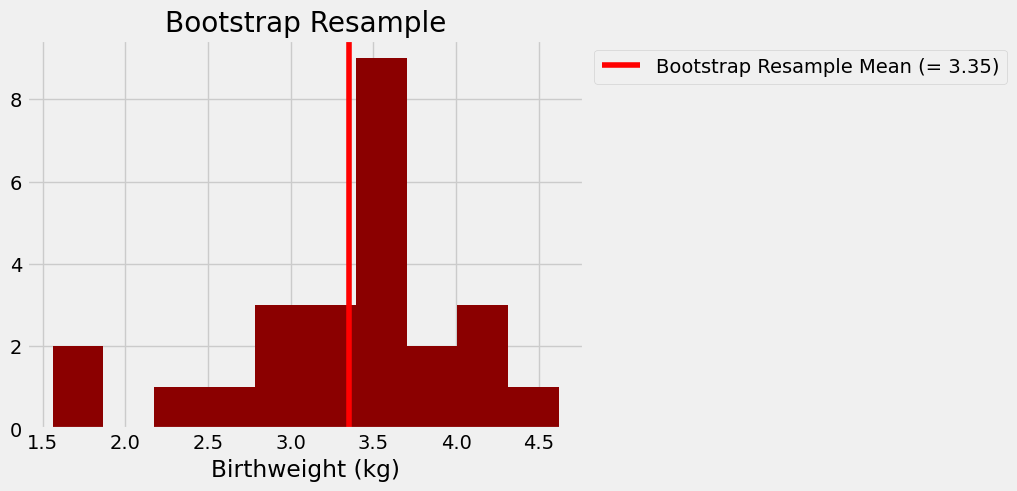

In [34]:
# draw a sample of size 25 from our original sample, with replacement.
bootstrap_resample = babies_sample['birthweight_kg'].sample(25, replace= True)

# show the sample
display(Markdown("New bootstrap resample:"))
display(pd.DataFrame({'birthweight_kg': bootstrap_resample}))

# plot a histogram of the sample
plt.hist(bootstrap_resample, color = 'darkred')
plt.axvline(bootstrap_resample.mean().round(2),
            color = 'red',
            label = f"Bootstrap Resample Mean (= {bootstrap_resample.mean().round(2)})")
plt.xlabel('Birthweight (kg)')
plt.title('Bootstrap Resample')
plt.legend(bbox_to_anchor = (1,1));

Each time we resample, we generate something like a new sample mean. By resampling again and again, we will get many such new sample means, allowing us to build a distribution of boostrapped sample means. 

This tells us how much sample means are likely to vary from each other as we draw repeated new random samples, and this information can be used to build a confidence interval. 

**But this time we aren't drawing any new samples from the population data** - e.g. we aren't relying on our rare and luxury perspective - in order to generate this distribution of sample means. We are "bootstrapping" this distribution from one random sample. So, this technique is available to our data scientist, using just the one sample she has!

## A distribution of means from bootstrap resamples

Let us define a function `bootstrap_mean` that takes our original sample,
and the number of bootstrap samples we want to take, and returns an array of
the corresponding bootstrap resample means.

In [35]:
def bootstrap_mean(original_sample, number_of_bootstrap_resamples):
    """Return array of bootstrapped sample means

    Parameters
    ----------
    original_sample: Series containing the original sample
    number_of_bootstrap_resamples: number of bootstrap resamples
    to perform

    Returns
    -------
    resampled_means : Array of bootstrapped sample means.
    """
    # calculate the length of the original sample
    n = len(original_sample)
    
    # create an empty array to store the estimate of the means
    # over repeated resamples
    resampled_means = np.zeros(number_of_bootstrap_resamples)

    # repeat the resampling procedure, and store the estimate of
    # the mean each time
    for i in np.arange(number_of_bootstrap_resamples):
        bootstrap_sample = original_sample.sample(n, replace=True)
        resampled_means[i] = np.mean(bootstrap_sample)
        
    # return the array of estimate means
    return resampled_means

We now repeat the bootstrap process 1000 times. The array `bstrap_means`
contains the means of all 1000 bootstrap samples:

In [36]:
# set the number of bootstrap resamples we want to generate
number_of_bootstrap_resamples = 1000

# run our function, to generate an array containing the bootstrapped means
bootstrap_sample_means = bootstrap_mean(babies_sample['birthweight_kg'], number_of_bootstrap_resamples)

# show the array
bootstrap_sample_means

array([3.4832, 3.6796, 3.6744, 3.508 , 3.8788, 3.392 , 3.612 , 3.5468,
       3.6644, 3.6628, 3.4776, 3.7232, 3.3404, 3.7376, 3.6208, 3.5544,
       3.7464, 3.3912, 3.426 , 3.7248, 3.6104, 3.3104, 3.6528, 3.6104,
       3.508 , 3.5404, 3.5448, 3.7996, 3.7448, 3.2332, 3.2764, 3.4464,
       3.6088, 3.6124, 3.2616, 3.5868, 3.4328, 3.4488, 3.3996, 3.5464,
       3.5132, 3.5816, 3.6044, 3.4748, 3.9104, 3.6516, 3.2288, 3.5476,
       3.478 , 3.2464, 3.4248, 3.4912, 3.384 , 3.6888, 3.2828, 3.2816,
       3.4364, 3.466 , 3.5216, 3.1728, 3.446 , 3.3748, 3.6056, 3.498 ,
       3.3528, 3.406 , 3.4968, 3.4452, 3.3112, 3.5488, 3.5312, 3.4204,
       3.5152, 3.0764, 3.5296, 3.4956, 3.5856, 3.648 , 3.4284, 3.69  ,
       3.3716, 3.4428, 3.4256, 3.5352, 3.8572, 3.5504, 3.3624, 3.6632,
       3.3028, 3.5264, 3.4996, 3.364 , 3.3928, 3.5432, 3.7276, 3.6376,
       3.2996, 3.5596, 3.5384, 3.3404, 3.3152, 3.4288, 3.496 , 3.7456,
       3.5056, 3.4156, 3.4248, 3.5996, 3.564 , 3.5512, 3.6548, 3.6444,
      

After running this function, we now have the we have the means from 1000 simulated samples.

**But we've gotten them all from our original random sample of 25 babies - we haven't touched the population data.**

Here is the histogram of the 1000 means from the bootstrap resamples; this gives us an estimate of how much sample means (from samples of size 25) tend to vary from each other:

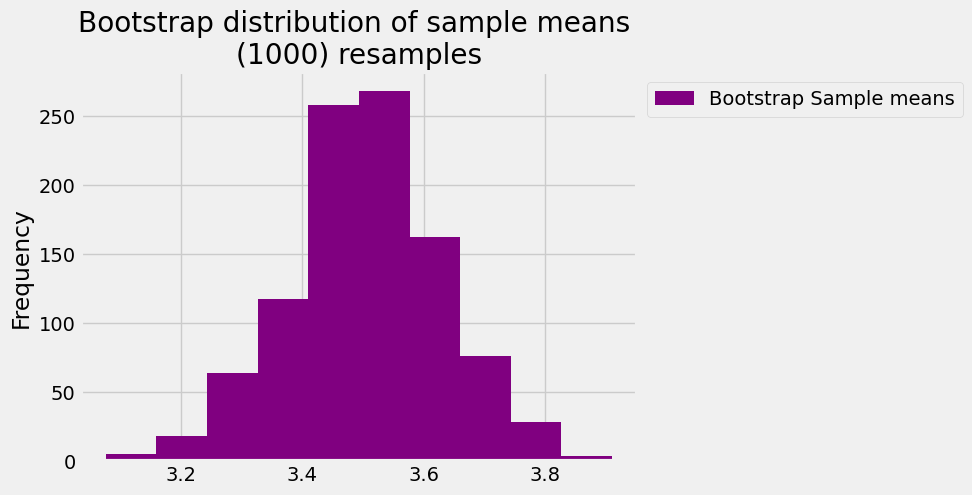

In [37]:
# a new dataframe for the means, obtained via resampling
resampled_means = pd.DataFrame()
resampled_means['Bootstrap Sample means'] = bootstrap_sample_means

# plot the distribution of bootstrapped means
resampled_means.plot.hist(color = 'purple')

# add title and labels to the plot
plt.title(f'Bootstrap distribution of sample means \n({number_of_bootstrap_resamples}) resamples')
plt.legend(bbox_to_anchor = (1, 1));

## Building a bootstrap confidence interval

Just to recap: earlier we used our "all-knowing" perspective to draw 1000 random samples directly from the population data. We then used the distribution of the means of those samples to build a confidence interval (using the width of the interval covering the middle 95% of the sample means).

*Well, now we've done something very similar through the bootstrap resampling - we've built a distribution of 1000 boostrap resample means - only we've done it from a single random sample, without accessing the population data.*

We can construct an interval the same way as before:

In [38]:
left_boostrap_interval, right_boostrap_interval = np.percentile(bootstrap_sample_means, [2.5, 97.5])
print('Left:', left_boostrap_interval)
print('Right:', right_boostrap_interval)

Left: 3.2487399999999993
Right: 3.7540400000000003


We can show the interval on the histogram of boostrap resample means:

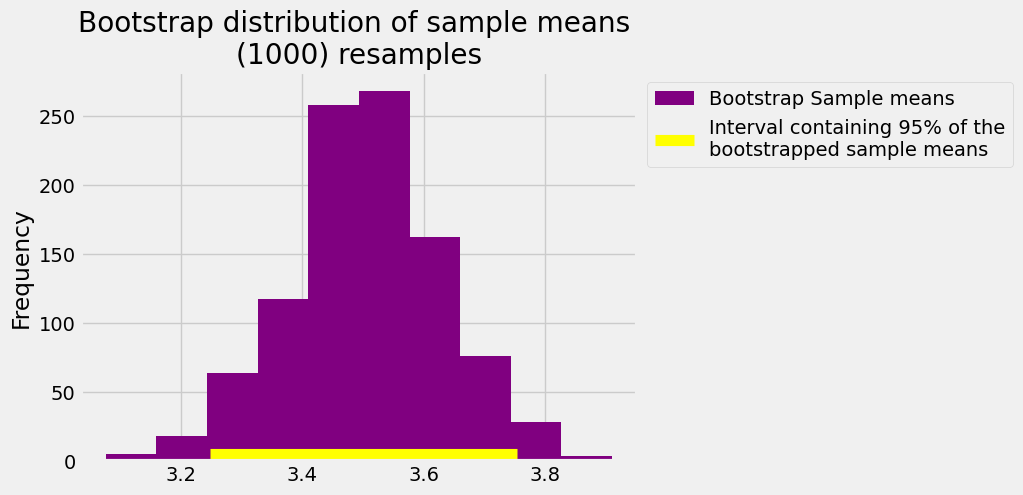

In [39]:
# show the boostrap resample distribution, and its middle 95%
resampled_means.plot.hist(color = 'purple')
plt.plot([left_boostrap_interval, right_boostrap_interval], [5, 5],
         color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nbootstrapped sample means")
plt.title(f'Bootstrap distribution of sample means \n({number_of_bootstrap_resamples}) resamples')
plt.legend(bbox_to_anchor = (1, 1));

Now, our data scientist can present this interval - obtained from boostrap resampling her single random sample - alongside her sample mean, as an "interval estimate" of where the population mean probably lies:

In [40]:
# mean of the original sample
sample_mean

3.5024

In [41]:
# get the width of the boostrap confidence interval
width_from_boostrap = right_boostrap_interval - left_boostrap_interval
width_from_boostrap

0.505300000000001

In [42]:
# minus "a bit" (from boostrap)
- width_from_boostrap/2

-0.2526500000000005

In [43]:
# plus "a bit" (from boostrap)
+ width_from_boostrap/2

0.2526500000000005

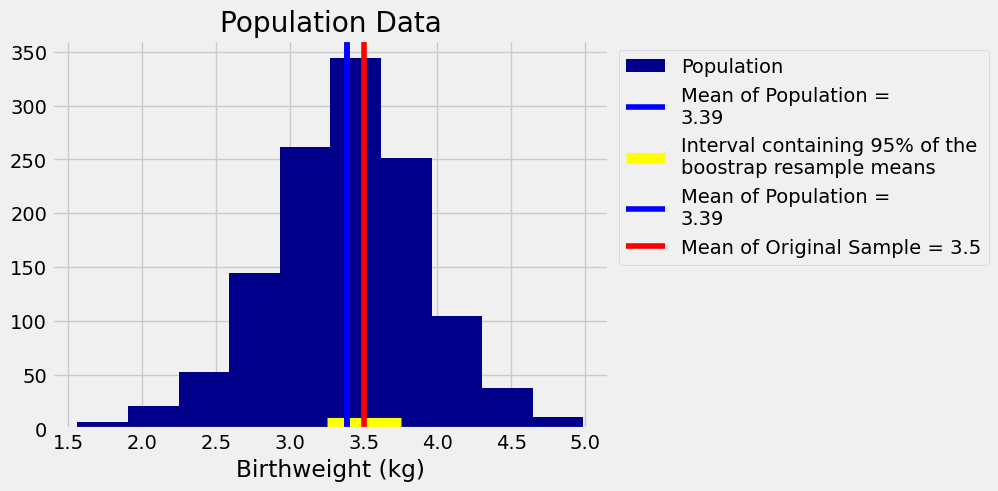

In [44]:
# show the sample mean, boostrap confidence interval, and the population data
# plot a histogram, show the pop and pop mean
plt.hist(babies_pop["birthweight_kg"], color = 'darkblue', 
         label = 'Population')

# show the population mean
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# plot the confidence interval
plt.plot([sample_mean - width_from_boostrap/2, sample_mean  + width_from_boostrap/2], [5, 5],
         color='yellow', lw=8, zorder=1,
         label = "Interval containing 95% of the\nboostrap resample means")

# plot the population mean
plt.axvline(babies_pop["birthweight_kg"].mean(), 
            label = f'Mean of Population = \n{population_mean}', 
            color = "blue")

# plot the sample mean
plt.axvline(sample_mean, color = "red",
            label = f'Mean of Original Sample = {sample_mean.round(2)}')
# add axis labels and legend
plt.xlabel('Birthweight (kg)')
plt.legend(bbox_to_anchor = (1,1))
plt.title('Population Data');

Just as with the confidence intervals we generated earlier from our all-knowing perspective, 95% of the time intervals generated via bootstrapping (from a single random sample) will contain the population mean. This allows our data scientist to make a claim to her colleagues like: "the population mean is probably within this boostrap confidence interval, centred on my sample mean" (and in this case, she would have been right!). 

> <b> Question </b>:  Do you believe bootstrap resampling generates confidence intervals that "work" as well as the ones we generated earlier, from our all-knowing perspective? E.g. will boostrap confidence intervals capture the population mean the same proportion of the time?

To answer this question let's return to our all-knowing perspective once more. Only now, let's enhance our powers. We can not only "see" the full population data, we can also rewind time. We repeat the following process:

* 1. We "travel" to the point in time where the data scientist is given her random sample of 25 baby records by the hospital.
* 2. She calculates its mean, and uses bootstrap resampling to generate a confidence interval.
* 3. From our all-knowing perspective, we're going to record if her boostrap confidence interval contains the population mean.
* 4. We use our powers to "rewind the tape of reality", back to step 1 above.

By "rewinding the tape of reality" like this, we can see how often boostrap confidence intervals capture the population mean, for new random samples. You can think of this as being about "possible worlds" - as our data scientist gets different random samples, over these possible worlds, what proportion of the time do boostrap confidence intervals actually capture the population mean?

**This is simulating our data scientist's scenario 100 times over - with 100 new random samples. We can then see how effective bootstrap confidence intervals would be for capturing the population mean, in each case, for each new sample.**

We'll show this process using some python code:

In [45]:
# THE BIG SIMULATION: this one can take a minute or two

# set up to make 20 left and right intervals, and sample means
n_intervals = 100
big_sim_left_ends = np.empty(n_intervals)
big_sim_right_ends = np.empty(n_intervals)
big_sim_random_sample_means = np.empty(n_intervals)

# repeat the following process, n_intervals number of times...
for i in np.arange(n_intervals):
    
    # tell the user how far through the simulation we are
    if i in np.arange(0, 101, 10):
        display(Markdown(f"{i}/{n_intervals} completed."))
    
    # simulate the hospital records department taking a new random sample.
    this_sample = babies_pop['birthweight_kg'].sample(25)
    
    # get the distribution of bootstrap resample means, from the single new sample
    big_sim_boostrap_sample_means = bootstrap_mean(this_sample, number_of_bootstrap_resamples)
    
    # calculate the left, right ends of the interval, for the current repeat
    current_left_end, current_right_end = np.percentile(big_sim_boostrap_sample_means, [2.5, 97.5])
    
    # store the results for this trial
    big_sim_left_ends[i] = current_left_end
    big_sim_right_ends[i] = current_right_end
    big_sim_random_sample_means[i] = this_sample.mean()

# show when done
display(Markdown(f"Completed!"))

# put interval ends into own data frame.
big_sim_intervals_and_means = pd.DataFrame()
big_sim_intervals_and_means['Sample Mean'] = big_sim_random_sample_means
big_sim_intervals_and_means['Left'] = big_sim_left_ends
big_sim_intervals_and_means['Right'] = big_sim_right_ends

0/100 completed.

10/100 completed.

20/100 completed.

30/100 completed.

40/100 completed.

50/100 completed.

60/100 completed.

70/100 completed.

80/100 completed.

90/100 completed.

Completed!

For each of the 100 repeats, we get one new random sample, and new sample mean, and a new boostrapped confidence interval (bootstrap resampled from the new random sample). What percentage of the intervals contain the population mean?

In [ ]:
# add a column to the intervals dataframe, showing if the interval captures the population mean
big_sim_intervals_and_means["Contains Population Mean"] = np.logical_and(big_sim_intervals_and_means['Left'] < population_mean,
                                                                         big_sim_intervals_and_means['Right'] > population_mean)
# show the percentage of boostrapped intervals which contain the mean
display(Markdown(f"{big_sim_intervals_and_means['Contains Population Mean'].sum()/len(big_sim_intervals_and_means) * 100}% of the intervals contained the population mean."))

# set the figure size
plt.figure(figsize=(10,10))

# plot the boostrap confidence intervals
for i in np.arange(len(intervals)):
    ends = big_sim_intervals_and_means[['Left', 'Right']].iloc[i]
    plt.scatter(big_sim_intervals_and_means["Sample Mean"][i], i,
                color='red', marker = "|")
    plt.plot(ends, [i, i], color='gold', zorder=0)
    
# show the population mean and add labels
plt.axvline(population_mean,  color='blue', label = 'Population mean')
plt.plot([], [], color = 'gold',
         label = "Intervals containing 95% of the\nbootstrap resample means for a given repeat")
plt.scatter([], [], color='red', marker = "|", label = "Sample mean")
plt.ylabel('Repeat Number')
plt.yticks(np.arange(0, n_intervals+1, 5))
plt.xlabel('Birthweight (kg)')
plt.title('Population mean and Boostrapped Intervals')
plt.legend(bbox_to_anchor = (1, 1));

## Summary

If we are in a godlike, all-knowing perspective, of having access to population data, we can construct confidence intervals by drawing many random samples from the population data. We can then plot the distribution of means from these samples, and then use the "width" of this distribution to construct confidence intervals...

BUT if we're in a real world situation - with no access to the full population data - we can use the boostrap:

- treat the random sample as if it is the population
- draw many new "bootstrap resamples" from the original sample, by sampling WITH replacement
- plot the distribution of means from these boostrap resamples
- use the "spread" of the distribution of boostrap means to construct our confidence interval

We have seen that boostrap confidence intervals will capture the population mean around 95% of the time, over many new random samples...

# If there is time: 

### Why does boostrapping work?

Why is this a good idea? On average, **random samples tend to resemble the population...so random bootstrap resamples of the sample tend to resemble the population as well**. This entails that when we generate bootstrap resamples, they provide pretty good estimates of how much the means of random samples tend to vary from each other (and this is in the information we need to build our confidence interval!).

![](images/bootstrap_pic_2.png)


### "Why are the sampling distributions normal?' - the Central Limit Theorem

Inspired by Agresti, Statistical Methods for 
                 the Social Sciences, 2018, 5th Ed., pg.100


An illustration of the central limit theorem. 
The code repeatedly draws samples (of three different sizes) from a set of
underlying population distributions (some of which are very non-normal).
A plot is then created showing that the sampling distribution of the mean gets
more precise and more normal as the sample size increases,
regardless of the (non)normality of the underlying population.

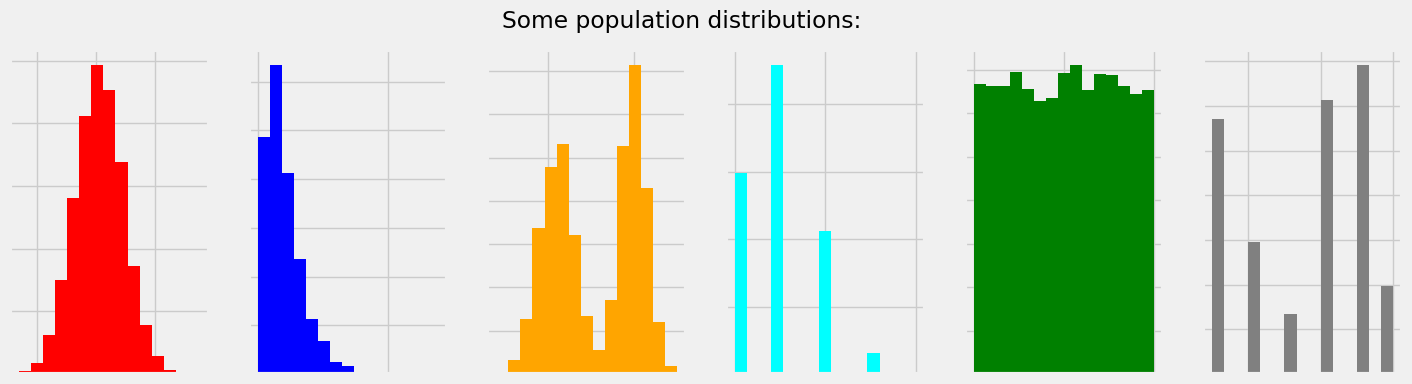

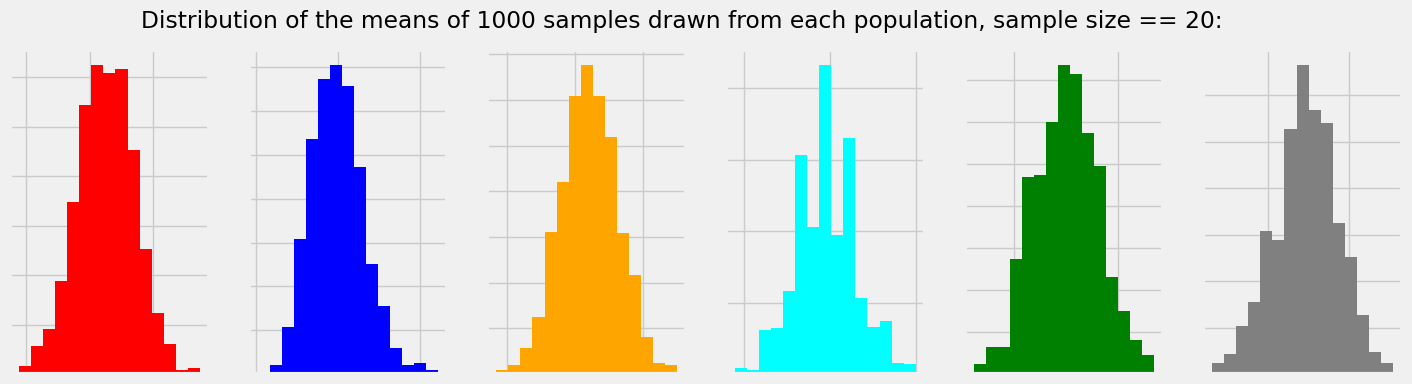

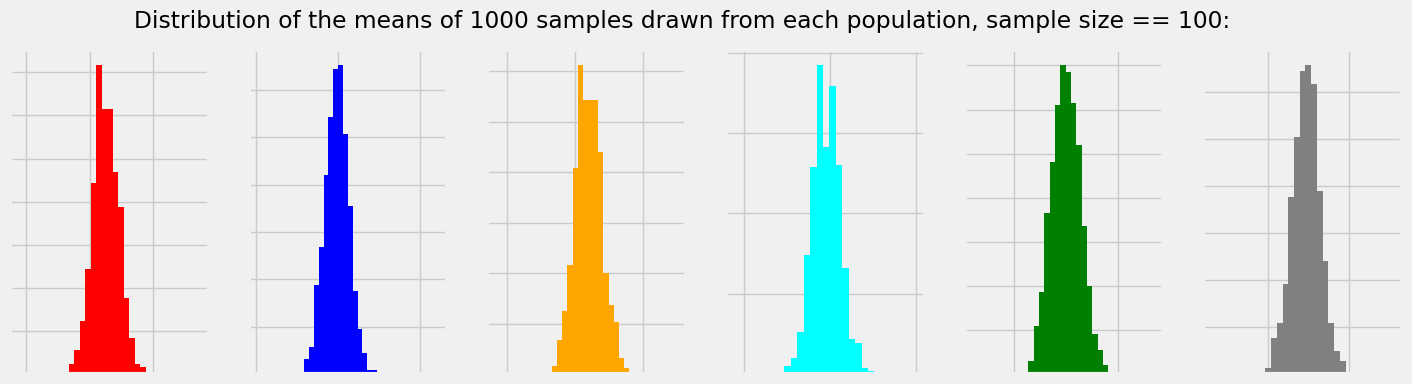

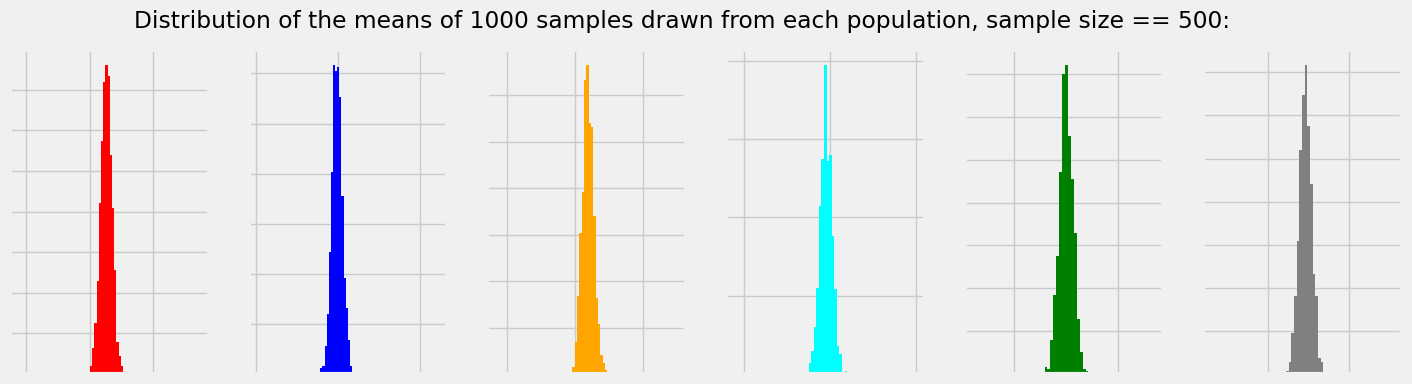

In [46]:
# print an explanation of the graph
display(Markdown("""Inspired by Agresti, Statistical Methods for 
                 the Social Sciences, 2018, 5th Ed., pg.100"""))
display(Markdown("""
An illustration of the central limit theorem. 
The code repeatedly draws samples (of three different sizes) from a set of
underlying population distributions (some of which are very non-normal).
A plot is then created showing that the sampling distribution of the mean gets
more precise and more normal as the sample size increases,
regardless of the (non)normality of the underlying population."""))

# show the graph
plot_CTL_illustration()

### What if we bootstrap from an unrepresentative sample?

A good way to think of boostrapping is this: over multiple labs and research projects trying to estimate the same population parameter (mean, median, odds ratio etc.), bootstrap confidence intervals will contain the population mean 95% of the time (as a proportion of the total research projects).

Because sampling is random, a given sample in a given research project may be unrepresentative. Bootstrapping cannot fix this is issue. **This is why replication and open science are so important!**.

A small proportion of the time we will be wrong, even with perfectly random sampling. However, for any sample we have, confidence intervals provide the best guide available to where the population parameter is. Over repeated replications, we will be right most of the time, if we trust the confidence intervals...

More from Stack Exchange: https://stats.stackexchange.com/questions/157639/bootstrapping-wont-always-return-population-statistics-so-why-say-it-does

*Note*: This page has content from the [Bootstrap](https://github.com/data-8/textbook/blob/64b20f0/notebooks/Bootstrap.ipynb)
notebook of an older version of the [UC Berkeley data science course](https://inferentialthinking.com/). See the Berkeley course section of the [license file](https://uob-ds.github.io/cfd2021/license).